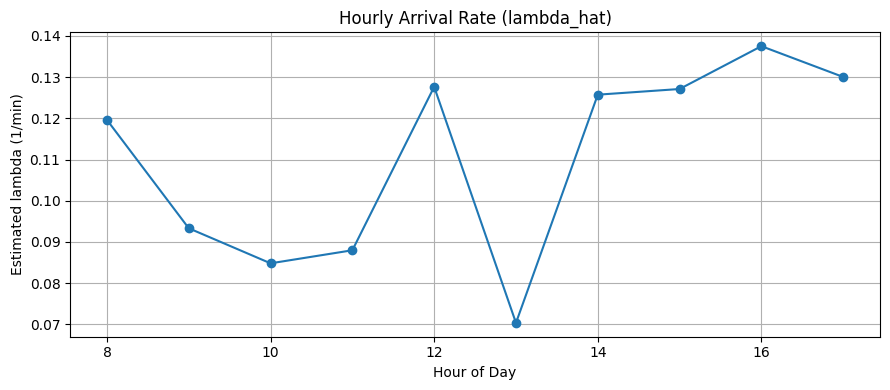


--- Final clusters (CV-based splitting) ---
Cluster 0: hours=[8, 9], avg_lambda=0.1065, CV=0.123 [OK]
Cluster 1: hours=[10, 11], avg_lambda=0.0864, CV=0.018 [OK]
Cluster 2: hours=[12, 13], avg_lambda=0.0990, CV=0.289 [WARN]
Cluster 3: hours=[14, 15], avg_lambda=0.1264, CV=0.005 [OK]
Cluster 4: hours=[16, 17], avg_lambda=0.1338, CV=0.028 [OK]


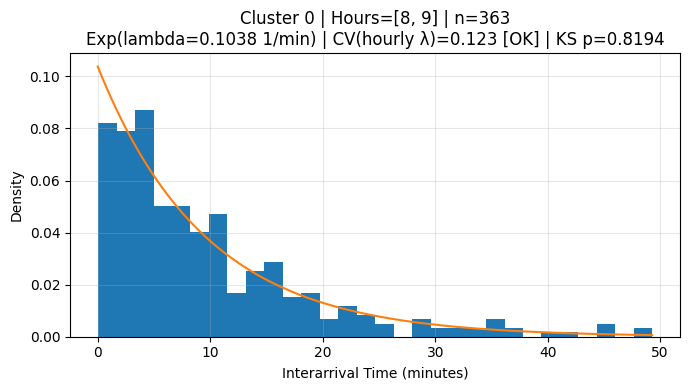

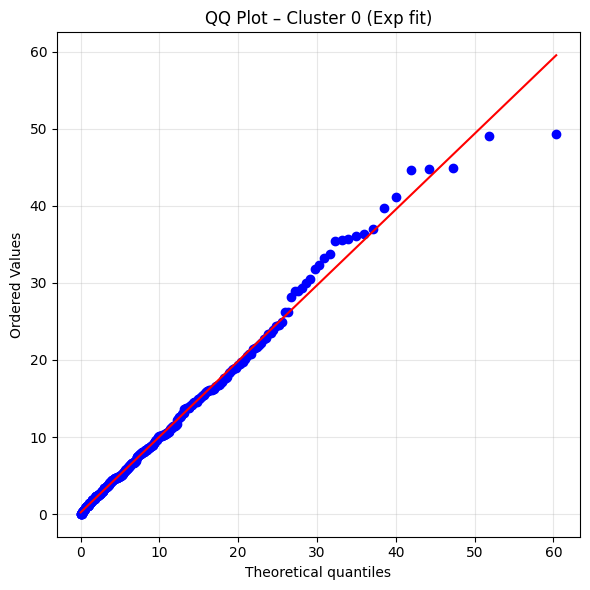

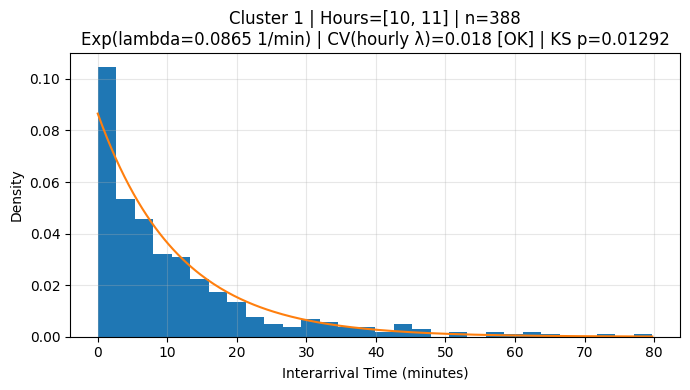

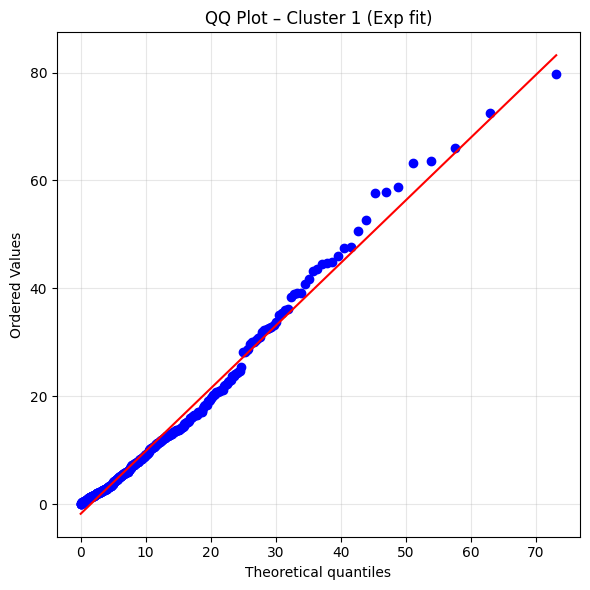

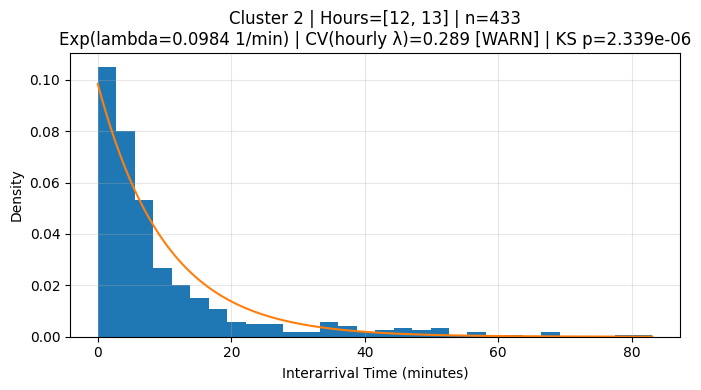

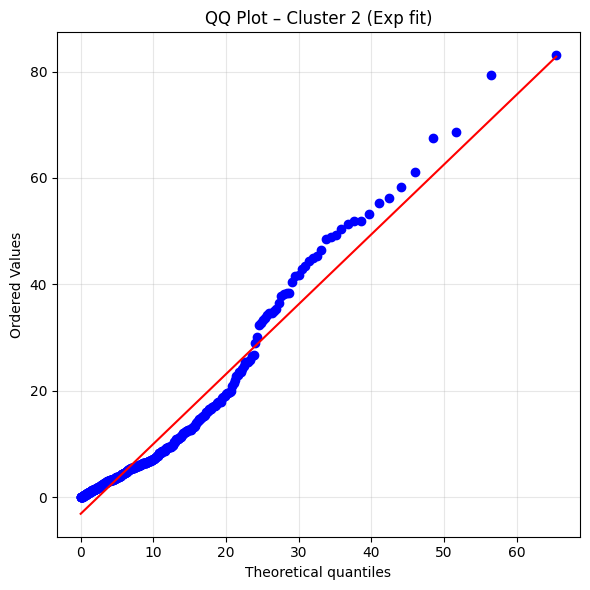

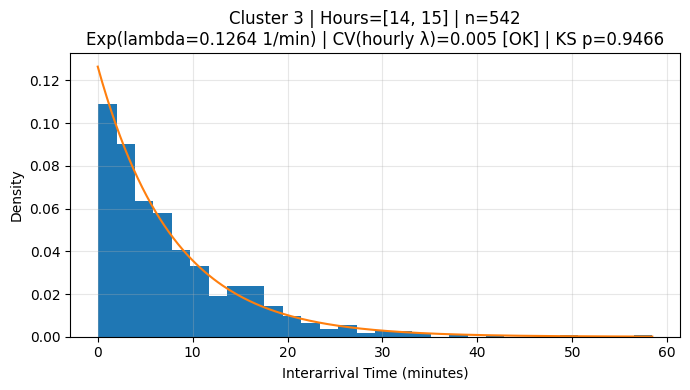

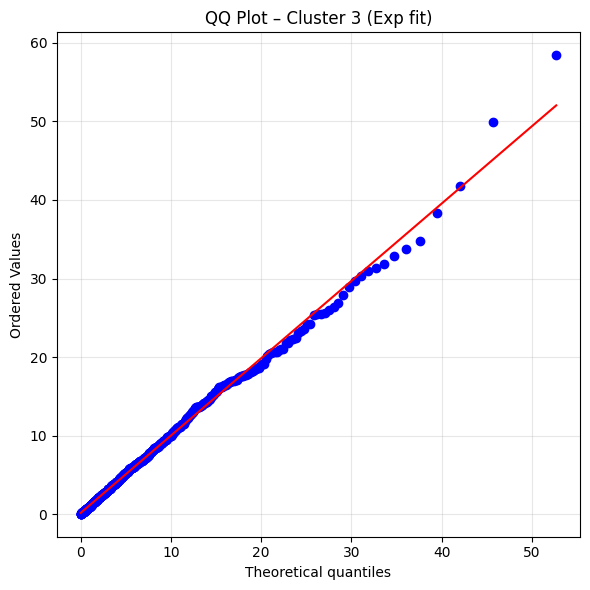

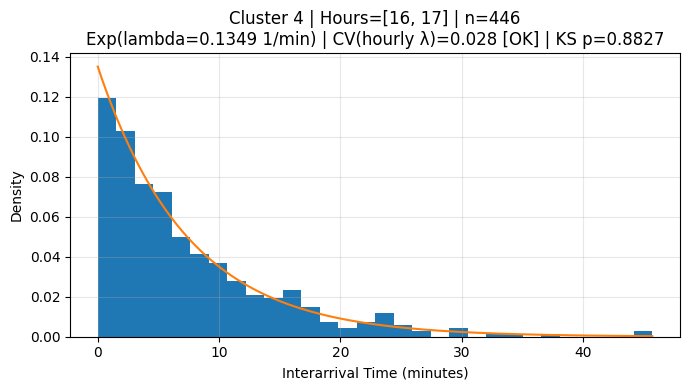

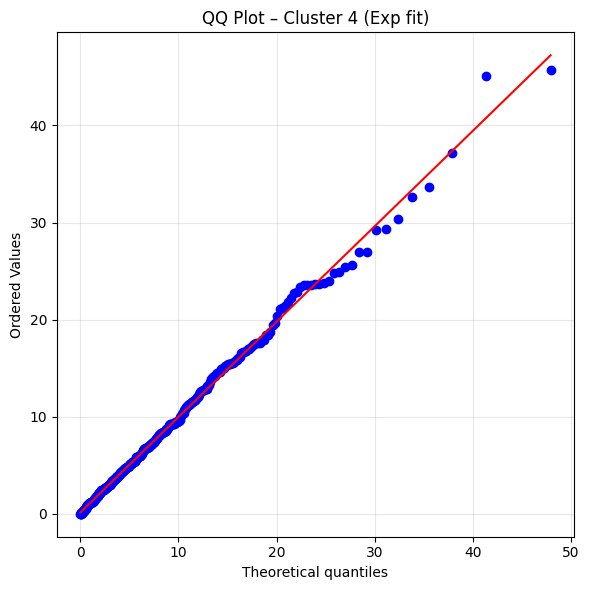


RESULTS TABLE
   Cluster Hours_in_Cluster    N  Mean_Interarrival_min  Lambda_fit_per_min  \
0        0              8,9  363               9.638200            0.103754   
1        1            10,11  388              11.555026            0.086542   
2        2            12,13  433              10.160893            0.098417   
3        3            14,15  542               7.908672            0.126443   
4        4            16,17  446               7.410164            0.134950   

       KS_D  KS_p_value  Avg_lambda_from_hourly  Std_lambda_from_hourly  \
0  0.032723    0.819389                0.106470                0.013143   
1  0.080146    0.012917                0.086408                0.001584   
2  0.125017    0.000002                0.099007                0.028634   
3  0.022202    0.946637                0.126424                0.000688   
4  0.027371    0.882652                0.133770                0.003735   

   CV_lambda_from_hourly Stability_Flag  
0               0

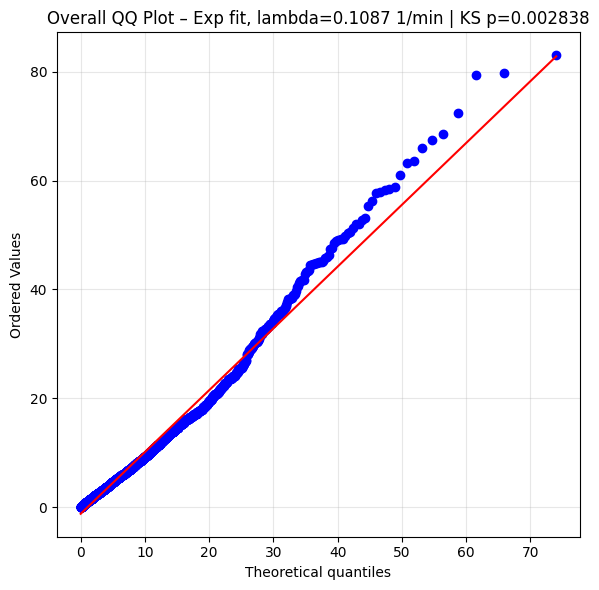

In [11]:
#
#
# Find time-of-day clusters where arrival rate is approximately constant
# Method:
# 1) Compute hourly lambdas (lambda_hat = 1/mean interarrival per hour)
# 2) Recursively split hour-intervals until lambda CV <= threshold
# 3) Fit Exp in each final segment and report KS p-value + plots
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import expon, kstest, probplot


#SETTINGS

FILE_PATH = "Customer_Data_Clean.xlsx"
ARRIVAL_COL = "ArrivalTime"

# Stability thresholds
CV_TARGET = 0.12              # aim: hourly-lambda CV <= 0.12 (12%)
CV_WARN_THRESHOLD = 0.15      # flag if CV > 0.15
MIN_HOURS_PER_CLUSTER = 2     # don't allow clusters with < 2 consecutive hours
MAX_CLUSTERS = 12             # safety cap (avoid infinite splitting)

# Plot / output
HIST_BINS = 30
EXPORT_RESULTS = True
RESULTS_XLSX = "cluster_exp_fit_results.xlsx"

SAVE_PLOTS = False
PLOT_DIR = "plots"

# 1) LOAD + PARSE DATETIME

df = pd.read_excel(FILE_PATH)
if ARRIVAL_COL not in df.columns:
    raise ValueError(f"Column '{ARRIVAL_COL}' not found. Available columns: {list(df.columns)}")

arrival_str = df[ARRIVAL_COL].astype(str)

# "YYYY-MM-DD 00:00:00 HH:MM:SS" -> build "YYYY-MM-DD HH:MM:SS"
df["Arrival_DT"] = pd.to_datetime(
    arrival_str.str.slice(0, 10) + " " + arrival_str.str.slice(-8),
    errors="coerce"
)

df = df.dropna(subset=["Arrival_DT"]).sort_values("Arrival_DT").reset_index(drop=True)


# 2) BUILD INTERARRIVAL (minutes) WITHIN EACH DAY

df["Date"] = df["Arrival_DT"].dt.date
df["Hour"] = df["Arrival_DT"].dt.hour

df["Interarrival_Time"] = (
    df.groupby("Date")["Arrival_DT"]
      .diff()
      .dt.total_seconds() / 60.0
)

df = df.dropna(subset=["Interarrival_Time"]).copy()
df = df[df["Interarrival_Time"] > 0].copy()

if len(df) < 10:
    raise ValueError("Too few interarrival observations after cleaning. Check ArrivalTime formatting.")


# 3) HOURLY LAMBDA ESTIMATION

hourly = (
    df.groupby("Hour")["Interarrival_Time"]
      .mean()
      .reset_index()
      .sort_values("Hour")
      .reset_index(drop=True)
)
hourly["lambda_hat"] = 1.0 / hourly["Interarrival_Time"]

hours_available = hourly["Hour"].astype(int).to_list()
hour_to_lambda = dict(zip(hourly["Hour"].astype(int), hourly["lambda_hat"].astype(float)))

# Plot hourly lambda
plt.figure(figsize=(9, 4))
plt.plot(hourly["Hour"], hourly["lambda_hat"], marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Estimated lambda (1/min)")
plt.title("Hourly Arrival Rate (lambda_hat)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 4) Helpers: CV + splitting logic

def consecutive_hours(hours):
    """Return sorted unique hours (assumed contiguous in our use-case)."""
    return sorted(list(set(int(h) for h in hours)))

def segment_lambda_stats(seg_hours):
    """Compute mean/std/CV of hourly lambdas within a segment of hours."""
    seg_hours = consecutive_hours(seg_hours)
    lam = np.array([hour_to_lambda[h] for h in seg_hours], dtype=float)
    lam_mean = lam.mean()
    lam_std = lam.std(ddof=0)
    cv = lam_std / lam_mean if lam_mean > 0 else np.nan
    return lam_mean, lam_std, cv

def best_split_point(seg_hours):
    """
    Choose a split point to reduce CV.
    We try all splits that respect MIN_HOURS_PER_CLUSTER on both sides,
    and pick the one minimizing (max(CV_left, CV_right)).
    """
    seg_hours = consecutive_hours(seg_hours)
    n = len(seg_hours)
    if n < 2 * MIN_HOURS_PER_CLUSTER:
        return None  # cannot split while respecting min size

    best = None
    best_score = np.inf

    # split between indices k-1 and k
    for k in range(MIN_HOURS_PER_CLUSTER, n - MIN_HOURS_PER_CLUSTER + 1):
        left = seg_hours[:k]
        right = seg_hours[k:]
        _, _, cv_left = segment_lambda_stats(left)
        _, _, cv_right = segment_lambda_stats(right)
        score = max(cv_left, cv_right)  # worst-side CV

        if score < best_score:
            best_score = score
            best = (left, right, cv_left, cv_right, score)

    return best


# 5) CV-based recursive splitting
#
# Start with the full available consecutive hour span
# (If your data only covers 8-17, that's what we split.)
initial_segment = consecutive_hours(hours_available)

segments = [initial_segment]

while True:
    if len(segments) >= MAX_CLUSTERS:
        break

    # Find the most "unstable" segment (highest CV) that is splittable
    cvs = []
    for idx, seg in enumerate(segments):
        _, _, cv = segment_lambda_stats(seg)
        cvs.append((cv, idx))

    # sort by descending CV
    cvs_sorted = sorted(cvs, key=lambda x: (-x[0], x[1]))

    split_done = False
    for cv_val, idx in cvs_sorted:
        seg = segments[idx]
        lam_mean, lam_std, cv = segment_lambda_stats(seg)

        if np.isnan(cv) or cv <= CV_TARGET:
            continue  # stable enough

        candidate = best_split_point(seg)
        if candidate is None:
            continue  # can't split due to min hours

        left, right, cv_left, cv_right, score = candidate

        # Replace this segment with two segments
        segments.pop(idx)
        segments.insert(idx, right)
        segments.insert(idx, left)

        split_done = True
        break

    if not split_done:
        break  # no further beneficial/possible splits

# Final segments (clusters)
clusters = [consecutive_hours(seg) for seg in segments]

print("\n--- Final clusters (CV-based splitting) ---")
for i, cl in enumerate(clusters):
    lam_mean, lam_std, cv = segment_lambda_stats(cl)
    flag = "WARN" if cv > CV_WARN_THRESHOLD else "OK"
    print(f"Cluster {i}: hours={cl}, avg_lambda={lam_mean:.4f}, CV={cv:.3f} [{flag}]")


# 6) Assign cluster labels to rows

def assign_cluster(hour):
    hour = int(hour)
    for i, cl in enumerate(clusters):
        if hour in cl:
            return i
    return np.nan

df["Cluster"] = df["Hour"].apply(assign_cluster)
df = df.dropna(subset=["Cluster"]).copy()
df["Cluster"] = df["Cluster"].astype(int)


# 7) Fit Exp per cluster + plots + KS

results = []

if SAVE_PLOTS:
    import os
    os.makedirs(PLOT_DIR, exist_ok=True)

for c in sorted(df["Cluster"].unique()):
    data_c = df.loc[df["Cluster"] == c, "Interarrival_Time"].dropna().to_numpy()
    n = len(data_c)

    mean_c = float(np.mean(data_c))
    lam_fit = 1.0 / mean_c

    # stability (from hourly lambdas)
    lam_mean_hourly, lam_std_hourly, cv_hourly = segment_lambda_stats(clusters[c])
    flag = "WARN" if cv_hourly > CV_WARN_THRESHOLD else "OK"

    # KS test vs fitted exponential
    D, p = kstest(data_c, "expon", args=(0, 1/lam_fit))

    # ---- Histogram + fitted Exp + p-value
    plt.figure(figsize=(7, 4))
    plt.hist(data_c, bins=HIST_BINS, density=True)

    x_vals = np.linspace(0, np.max(data_c), 250)
    plt.plot(x_vals, lam_fit * np.exp(-lam_fit * x_vals))

    plt.xlabel("Interarrival Time (minutes)")
    plt.ylabel("Density")
    plt.title(
        f"Cluster {c} | Hours={clusters[c]} | n={n}\n"
        f"Exp(lambda={lam_fit:.4f} 1/min) | CV(hourly λ)={cv_hourly:.3f} [{flag}] | KS p={p:.4g}"
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if SAVE_PLOTS:
        plt.savefig(f"{PLOT_DIR}/hist_cluster_{c}.png", dpi=200)
    plt.show()

    # ---- QQ plot
    plt.figure(figsize=(6, 6))
    probplot(data_c, dist=expon(scale=1/lam_fit), plot=plt)
    plt.title(f"QQ Plot – Cluster {c} (Exp fit)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if SAVE_PLOTS:
        plt.savefig(f"{PLOT_DIR}/qq_cluster_{c}.png", dpi=200)
    plt.show()

    results.append({
        "Cluster": c,
        "Hours_in_Cluster": ",".join(map(str, clusters[c])),
        "N": n,
        "Mean_Interarrival_min": mean_c,
        "Lambda_fit_per_min": lam_fit,
        "KS_D": D,
        "KS_p_value": p,
        "Avg_lambda_from_hourly": lam_mean_hourly,
        "Std_lambda_from_hourly": lam_std_hourly,
        "CV_lambda_from_hourly": cv_hourly,
        "Stability_Flag": flag
    })

results_df = pd.DataFrame(results).sort_values("Cluster").reset_index(drop=True)

print("\n====================")
print("RESULTS TABLE")
print("====================")
print(results_df)

if EXPORT_RESULTS:
    results_df.to_excel(RESULTS_XLSX, index=False)
    print(f"\nSaved results to: {RESULTS_XLSX}")

#
# 8) Optional overall QQ + KS
#
all_data = df["Interarrival_Time"].to_numpy()
lam_all = 1.0 / all_data.mean()
D_all, p_all = kstest(all_data, "expon", args=(0, 1/lam_all))

plt.figure(figsize=(6, 6))
probplot(all_data, dist=expon(scale=1/lam_all), plot=plt)
plt.title(f"Overall QQ Plot – Exp fit, lambda={lam_all:.4f} 1/min | KS p={p_all:.4g}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



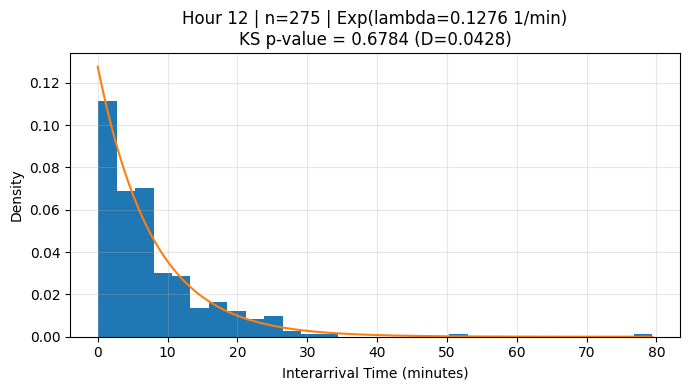

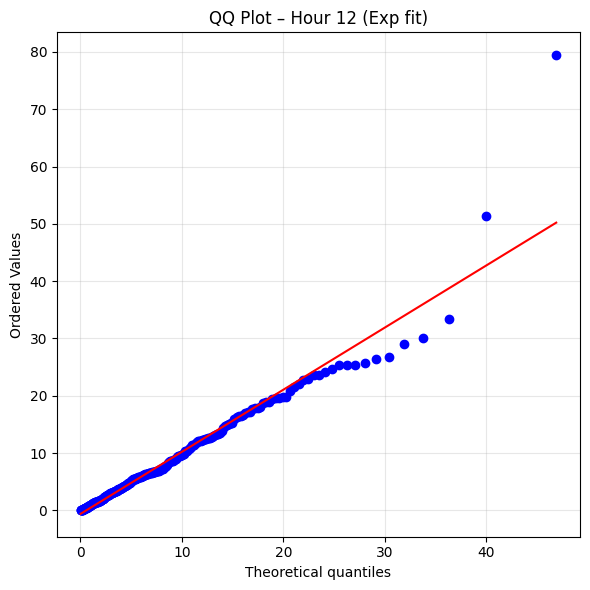

Hour 12 summary:
  n = 275
  mean(interarrival) = 7.8345 min
  lambda_hat = 0.127641 1/min
  KS: D = 0.0428, p = 0.678404



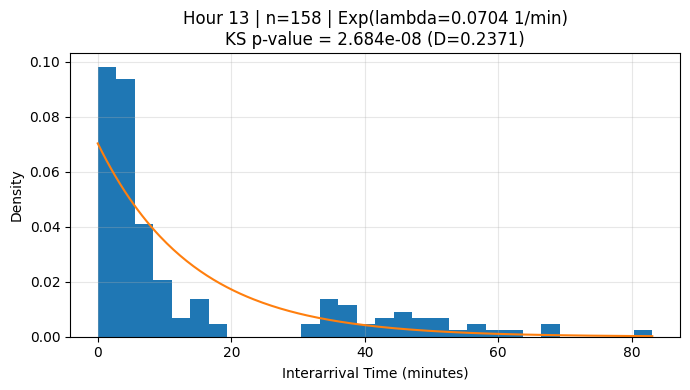

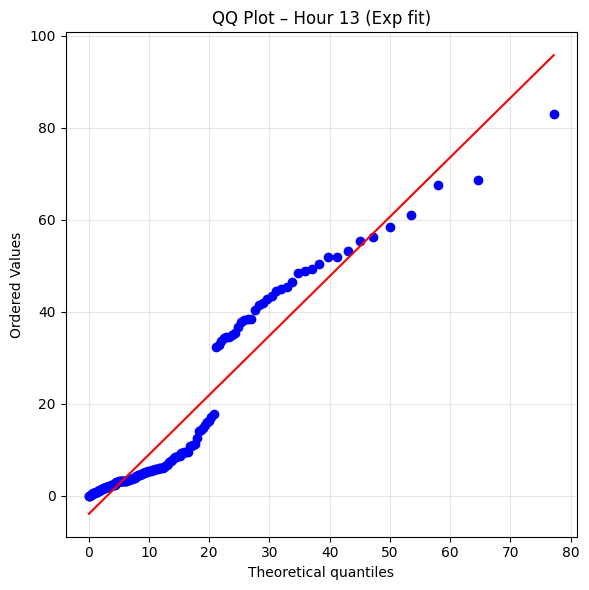

Hour 13 summary:
  n = 158
  mean(interarrival) = 14.2100 min
  lambda_hat = 0.070373 1/min
  KS: D = 0.2371, p = 2.68432e-08



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest, probplot

FILE_PATH = "Customer_Data_Clean.xlsx"
ARRIVAL_COL = "ArrivalTime"
HIST_BINS = 30


# 1) Load + parse datetime

df = pd.read_excel(FILE_PATH)

arrival_str = df[ARRIVAL_COL].astype(str)
df["Arrival_DT"] = pd.to_datetime(
    arrival_str.str.slice(0, 10) + " " + arrival_str.str.slice(-8),
    errors="coerce"
)

df = df.dropna(subset=["Arrival_DT"]).sort_values("Arrival_DT").reset_index(drop=True)
df["Date"] = df["Arrival_DT"].dt.date
df["Hour"] = df["Arrival_DT"].dt.hour

# interarrival (minutes) within each day
df["Interarrival_Time"] = (
    df.groupby("Date")["Arrival_DT"]
      .diff()
      .dt.total_seconds() / 60.0
)

df = df.dropna(subset=["Interarrival_Time"]).copy()
df = df[df["Interarrival_Time"] > 0].copy()


# 2) Analysis function

def analyze_single_hour(target_hour: int):
    data = df.loc[df["Hour"] == target_hour, "Interarrival_Time"].dropna().to_numpy()
    n = len(data)
    if n < 20:
        print(f"[WARN] Hour {target_hour}: n={n} (çok az veri)")

    mean_x = float(np.mean(data))
    lam = 1.0 / mean_x

    # KS test vs fitted exponential
    D, p = kstest(data, "expon", args=(0, 1/lam))

    # Histogram + fitted exp pdf
    plt.figure(figsize=(7,4))
    plt.hist(data, bins=HIST_BINS, density=True)

    x_vals = np.linspace(0, np.max(data), 250)
    plt.plot(x_vals, lam * np.exp(-lam * x_vals))

    plt.xlabel("Interarrival Time (minutes)")
    plt.ylabel("Density")
    plt.title(
        f"Hour {target_hour} | n={n} | Exp(lambda={lam:.4f} 1/min)\n"
        f"KS p-value = {p:.4g} (D={D:.4f})"
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,6))
    probplot(data, dist=expon(scale=1/lam), plot=plt)
    plt.title(f"QQ Plot – Hour {target_hour} (Exp fit)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Quick numeric summary
    print(
        f"Hour {target_hour} summary:\n"
        f"  n = {n}\n"
        f"  mean(interarrival) = {mean_x:.4f} min\n"
        f"  lambda_hat = {lam:.6f} 1/min\n"
        f"  KS: D = {D:.4f}, p = {p:.6g}\n"
    )


# 3) Run for 12 and 13 separately

analyze_single_hour(12)
analyze_single_hour(13)


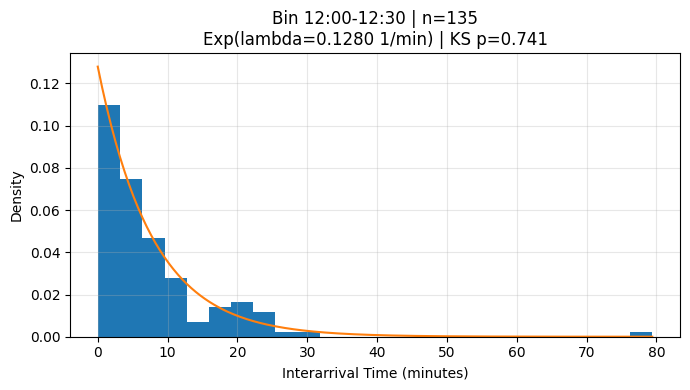

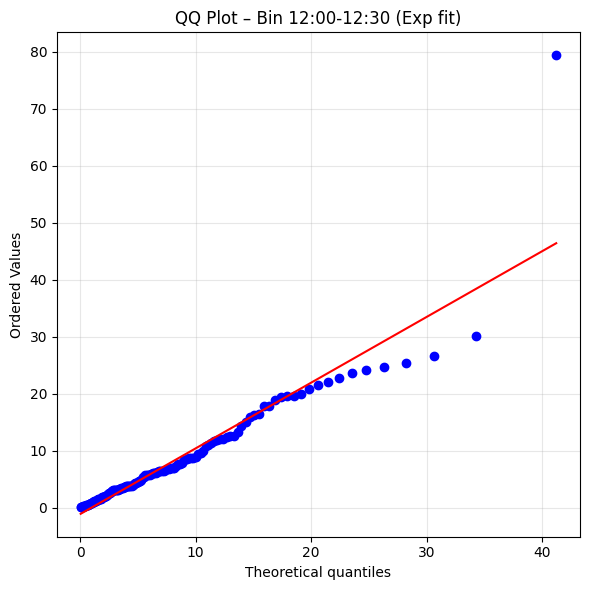

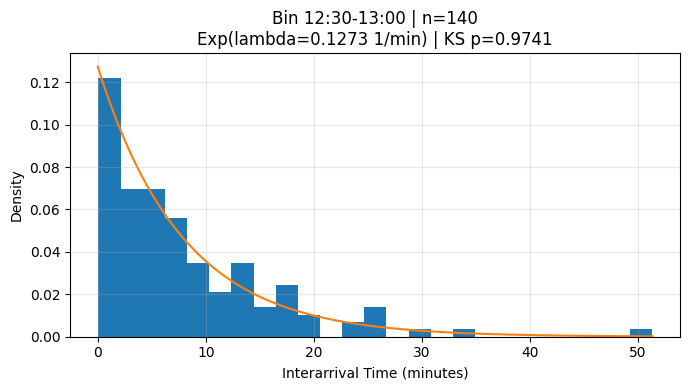

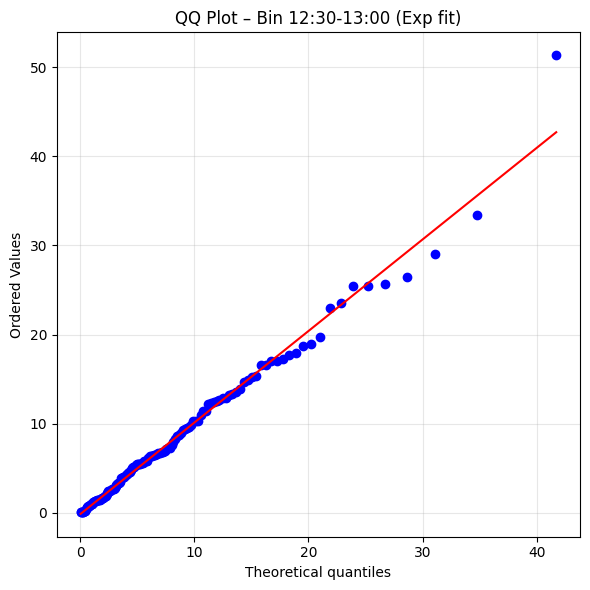

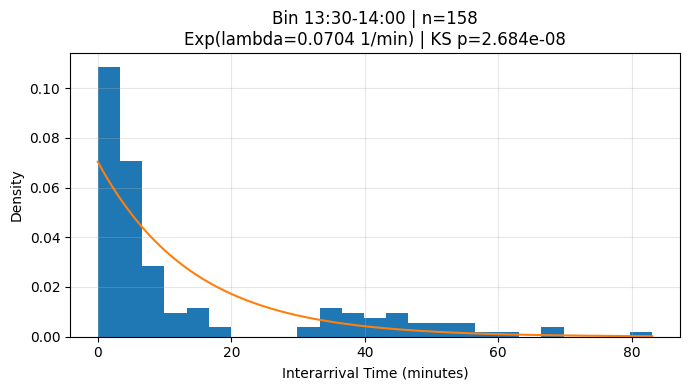

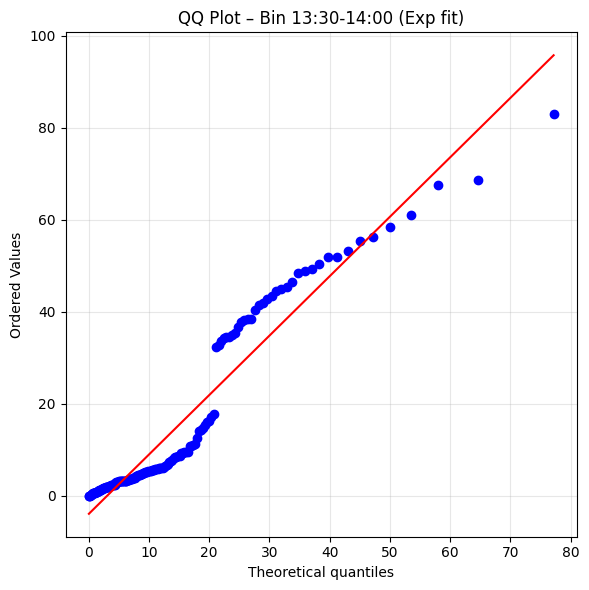


=== 12:00–14:00 bin summary ===
      BinLabel    n  MeanInterarrival_min  Lambda_hat_per_min      KS_D  \
0  12:00-12:30  135              7.813951            0.127976  0.057515   
1  12:30-13:00  140              7.854286            0.127319  0.039667   
2  13:30-14:00  158             14.210021            0.070373  0.237089   

     KS_p_value  
0  7.410054e-01  
1  9.740655e-01  
2  2.684322e-08  


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest, probplot

FILE_PATH = "Customer_Data_Clean.xlsx"
ARRIVAL_COL = "ArrivalTime"
HIST_BINS = 25

BIN_MINUTES = 30   # 30 dk için 30, 20 dk için 20 yap


# Load + parse datetime

df = pd.read_excel(FILE_PATH)

arrival_str = df[ARRIVAL_COL].astype(str)
df["Arrival_DT"] = pd.to_datetime(
    arrival_str.str.slice(0, 10) + " " + arrival_str.str.slice(-8),
    errors="coerce"
)

df = df.dropna(subset=["Arrival_DT"]).sort_values("Arrival_DT").reset_index(drop=True)
df["Date"] = df["Arrival_DT"].dt.date
df["Hour"] = df["Arrival_DT"].dt.hour
df["Minute"] = df["Arrival_DT"].dt.minute

# Interarrival (minutes) within each day
df["Interarrival_Time"] = (
    df.groupby("Date")["Arrival_DT"]
      .diff()
      .dt.total_seconds() / 60.0
)

df = df.dropna(subset=["Interarrival_Time"]).copy()
df = df[df["Interarrival_Time"] > 0].copy()


# 12:00–14:00 (covers hour 12 and 13 + bins inside)
# We'll include arrivals where time-of-day is in [12:00, 14:00)

tod_minutes = df["Hour"] * 60 + df["Minute"]
df["TOD_min"] = tod_minutes

window = df[(df["TOD_min"] >= 12*60) & (df["TOD_min"] < 14*60)].copy()

# Create bin index inside [12:00, 14:00)
# bin 0: 12:00–12:BIN
# bin 1: 12:BIN–13:00 ...
window["Bin"] = ((window["TOD_min"] - 12*60) // BIN_MINUTES).astype(int)

def bin_label(b):
    start = 12*60 + b*BIN_MINUTES
    end = start + BIN_MINUTES
    sh, sm = start // 60, start % 60
    eh, em = end // 60, end % 60
    return f"{sh:02d}:{sm:02d}-{eh:02d}:{em:02d}"

window["BinLabel"] = window["Bin"].apply(bin_label)


# Analyze each bin separately

summary_rows = []

for b in sorted(window["Bin"].unique()):
    data_b = window.loc[window["Bin"] == b, "Interarrival_Time"].to_numpy()
    label = bin_label(b)
    n = len(data_b)

    if n < 30:
        print(f"[WARN] Bin {label} has low n={n}. Consider using 30-min bins if too small.")

    mean_x = float(np.mean(data_b))
    lam = 1.0 / mean_x

    D, p = kstest(data_b, "expon", args=(0, 1/lam))

    # Histogram + fitted exp
    plt.figure(figsize=(7,4))
    plt.hist(data_b, bins=HIST_BINS, density=True)

    x_vals = np.linspace(0, np.max(data_b), 250)
    plt.plot(x_vals, lam * np.exp(-lam * x_vals))

    plt.xlabel("Interarrival Time (minutes)")
    plt.ylabel("Density")
    plt.title(
        f"Bin {label} | n={n}\nExp(lambda={lam:.4f} 1/min) | KS p={p:.4g}"
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,6))
    probplot(data_b, dist=expon(scale=1/lam), plot=plt)
    plt.title(f"QQ Plot – Bin {label} (Exp fit)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    summary_rows.append({
        "BinLabel": label,
        "n": n,
        "MeanInterarrival_min": mean_x,
        "Lambda_hat_per_min": lam,
        "KS_D": D,
        "KS_p_value": p
    })

summary_df = pd.DataFrame(summary_rows).sort_values("BinLabel").reset_index(drop=True)
print("\n=== 12:00–14:00 bin summary ===")
print(summary_df)


13:30–14:00 sample size n = 158

Exponential fit:
  mean = 14.2100
  lambda = 0.070373
  KS p-value = 2.68432e-08

Gamma fit:
  shape (k) = 0.6499
  scale (θ) = 21.8653
  mean = k*θ = 14.2100
  KS p-value = 0.0014591


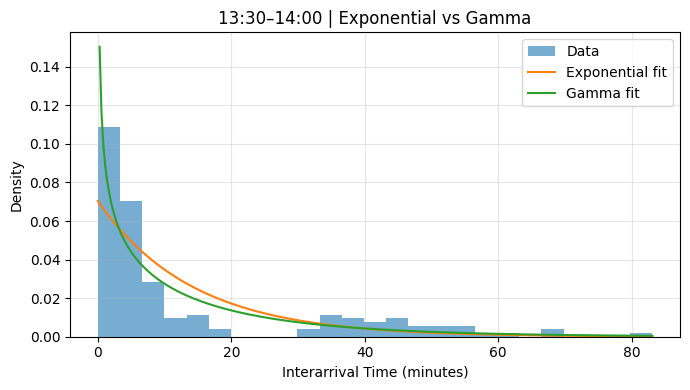

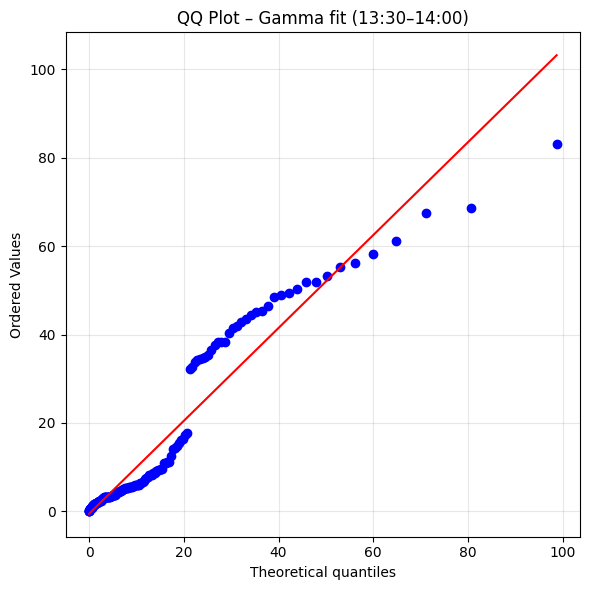

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, kstest, probplot

FILE_PATH = "Customer_Data_Clean.xlsx"
ARRIVAL_COL = "ArrivalTime"
HIST_BINS = 25

# Load + parse datetime

df = pd.read_excel(FILE_PATH)

arrival_str = df[ARRIVAL_COL].astype(str)
df["Arrival_DT"] = pd.to_datetime(
    arrival_str.str.slice(0, 10) + " " + arrival_str.str.slice(-8),
    errors="coerce"
)

df = df.dropna(subset=["Arrival_DT"]).sort_values("Arrival_DT").reset_index(drop=True)
df["Date"] = df["Arrival_DT"].dt.date
df["Hour"] = df["Arrival_DT"].dt.hour
df["Minute"] = df["Arrival_DT"].dt.minute

# Interarrival (minutes) within each day
df["Interarrival_Time"] = (
    df.groupby("Date")["Arrival_DT"]
      .diff()
      .dt.total_seconds() / 60.0
)
df = df.dropna(subset=["Interarrival_Time"]).copy()
df = df[df["Interarrival_Time"] > 0].copy()

# Filter: 13:30–14:00

df["TOD_min"] = df["Hour"] * 60 + df["Minute"]
data = df[
    (df["TOD_min"] >= 13*60 + 30) &
    (df["TOD_min"] < 14*60)
]["Interarrival_Time"].to_numpy()

n = len(data)
print(f"13:30–14:00 sample size n = {n}")


# Fit Exponential (baseline)

mean_exp = np.mean(data)
lam_exp = 1.0 / mean_exp
D_exp, p_exp = kstest(data, "expon", args=(0, 1/lam_exp))

print("\nExponential fit:")
print(f"  mean = {mean_exp:.4f}")
print(f"  lambda = {lam_exp:.6f}")
print(f"  KS p-value = {p_exp:.6g}")


# Fit Gamma (shape, scale)
# force loc=0

shape, loc, scale = gamma.fit(data, floc=0)

D_gam, p_gam = kstest(data, "gamma", args=(shape, 0, scale))

print("\nGamma fit:")
print(f"  shape (k) = {shape:.4f}")
print(f"  scale (θ) = {scale:.4f}")
print(f"  mean = k*θ = {shape*scale:.4f}")
print(f"  KS p-value = {p_gam:.6g}")


# Histogram + PDFs

plt.figure(figsize=(7,4))
plt.hist(data, bins=HIST_BINS, density=True, alpha=0.6, label="Data")

x = np.linspace(0, np.max(data), 300)
plt.plot(x, lam_exp * np.exp(-lam_exp * x), label="Exponential fit")
plt.plot(x, gamma.pdf(x, shape, loc=0, scale=scale), label="Gamma fit")

plt.xlabel("Interarrival Time (minutes)")
plt.ylabel("Density")
plt.title("13:30–14:00 | Exponential vs Gamma")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# QQ plot for Gamma

plt.figure(figsize=(6,6))
probplot(data, dist=gamma(shape, loc=0, scale=scale), plot=plt)
plt.title("QQ Plot – Gamma fit (13:30–14:00)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


13:30–14:00 n = 158

=== KS p-values ===
Exponential: p = 2.68432e-08, D = 0.2371, lambda = 0.070373
Gamma:       p = 0.0014591, D = 0.1499, k = 0.6499, theta = 21.8653
Lognormal:   p = 0.0947674, D = 0.0971, sigma = 1.5674, scale = 5.5522

=== AIC (lower is better) ===
Exponential AIC: 1156.65
Gamma       AIC: 1135.47
Lognormal   AIC: 1136.09


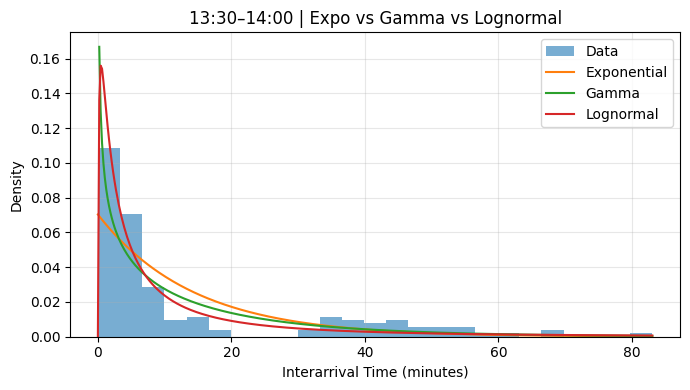

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, lognorm, kstest

FILE_PATH = "Customer_Data_Clean.xlsx"
ARRIVAL_COL = "ArrivalTime"
HIST_BINS = 25

#
# Load + parse datetime
#
df = pd.read_excel(FILE_PATH)
arrival_str = df[ARRIVAL_COL].astype(str)
df["Arrival_DT"] = pd.to_datetime(
    arrival_str.str.slice(0, 10) + " " + arrival_str.str.slice(-8),
    errors="coerce"
)
df = df.dropna(subset=["Arrival_DT"]).sort_values("Arrival_DT").reset_index(drop=True)

df["Date"] = df["Arrival_DT"].dt.date
df["Hour"] = df["Arrival_DT"].dt.hour
df["Minute"] = df["Arrival_DT"].dt.minute

df["Interarrival_Time"] = (
    df.groupby("Date")["Arrival_DT"]
      .diff()
      .dt.total_seconds() / 60.0
)
df = df.dropna(subset=["Interarrival_Time"]).copy()
df = df[df["Interarrival_Time"] > 0].copy()


# Filter: 13:30–14:00

df["TOD_min"] = df["Hour"] * 60 + df["Minute"]
data = df[(df["TOD_min"] >= 13*60 + 30) & (df["TOD_min"] < 14*60)]["Interarrival_Time"].to_numpy()
n = len(data)
print(f"13:30–14:00 n = {n}")

# Helper: AIC
def aic(loglik, k_params):
    return 2*k_params - 2*loglik


# Exponential fit

mean_exp = data.mean()
lam_exp = 1.0 / mean_exp
loglik_exp = np.sum(expon.logpdf(data, loc=0, scale=1/lam_exp))
D_exp, p_exp = kstest(data, "expon", args=(0, 1/lam_exp))
aic_exp = aic(loglik_exp, k_params=1)  # scale only (loc fixed 0)


# Gamma fit (loc fixed 0)

k_g, loc_g, theta_g = gamma.fit(data, floc=0)
loglik_g = np.sum(gamma.logpdf(data, a=k_g, loc=0, scale=theta_g))
D_g, p_g = kstest(data, "gamma", args=(k_g, 0, theta_g))
aic_g = aic(loglik_g, k_params=2)  # shape + scale


# Lognormal fit (loc fixed 0)

sigma_ln, loc_ln, scale_ln = lognorm.fit(data, floc=0)
loglik_ln = np.sum(lognorm.logpdf(data, s=sigma_ln, loc=0, scale=scale_ln))
D_ln, p_ln = kstest(data, "lognorm", args=(sigma_ln, 0, scale_ln))
aic_ln = aic(loglik_ln, k_params=2)  # sigma + scale (mu via scale)


# Print comparison

print("\n=== KS p-values ===")
print(f"Exponential: p = {p_exp:.6g}, D = {D_exp:.4f}, lambda = {lam_exp:.6f}")
print(f"Gamma:       p = {p_g:.6g}, D = {D_g:.4f}, k = {k_g:.4f}, theta = {theta_g:.4f}")
print(f"Lognormal:   p = {p_ln:.6g}, D = {D_ln:.4f}, sigma = {sigma_ln:.4f}, scale = {scale_ln:.4f}")

print("\n=== AIC (lower is better) ===")
print(f"Exponential AIC: {aic_exp:.2f}")
print(f"Gamma       AIC: {aic_g:.2f}")
print(f"Lognormal   AIC: {aic_ln:.2f}")


# Plot histogram + PDFs

plt.figure(figsize=(7,4))
plt.hist(data, bins=HIST_BINS, density=True, alpha=0.6, label="Data")

x = np.linspace(0, np.max(data), 400)
plt.plot(x, expon.pdf(x, loc=0, scale=1/lam_exp), label="Exponential")
plt.plot(x, gamma.pdf(x, a=k_g, loc=0, scale=theta_g), label="Gamma")
plt.plot(x, lognorm.pdf(x, s=sigma_ln, loc=0, scale=scale_ln), label="Lognormal")

plt.xlabel("Interarrival Time (minutes)")
plt.ylabel("Density")
plt.title("13:30–14:00 | Expo vs Gamma vs Lognormal")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
